
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


### TODO:
- notebook antiguo para dibujar extremos
- se mantiene en repositorio hasta asegurar que el nuevo "14_Validacion" funciona correctamente


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, Aggregate_WavesFamilies
from teslakit.extremes import Peaks_Over_Threshold as POT

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load data for extremes analysis

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time limits
WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# number of simulations to use
n_sims_DWTs = 10



## Aggregate Waves,  calculate Atmospheric Water Level

In [4]:
# Historical
WVS_hist = Aggregate_WavesFamilies(WVS_fit)
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp)

# Simulations: 1 x ALR_DWTs --> 1 x CE_WAVEs
l_WVS_sim_a = []
for n in range(n_sims_DWTs):
    
    # Load simulation
    _, _, WVS_upd = CE.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = 0)  # (one CE sim. for each DWT sim.)
    
    # aggregate data, calculate AWL
    WVS_sim_a = Aggregate_WavesFamilies(WVS_upd)
    WVS_sim_a['DWT'] = WVS_upd.DWT 
    WVS_sim_a['AWL'] = AWL(WVS_sim_a.Hs, WVS_sim_a.Tp)
    
    l_WVS_sim_a.append(WVS_sim_a)



## Climate Emulator - Annual Maxima

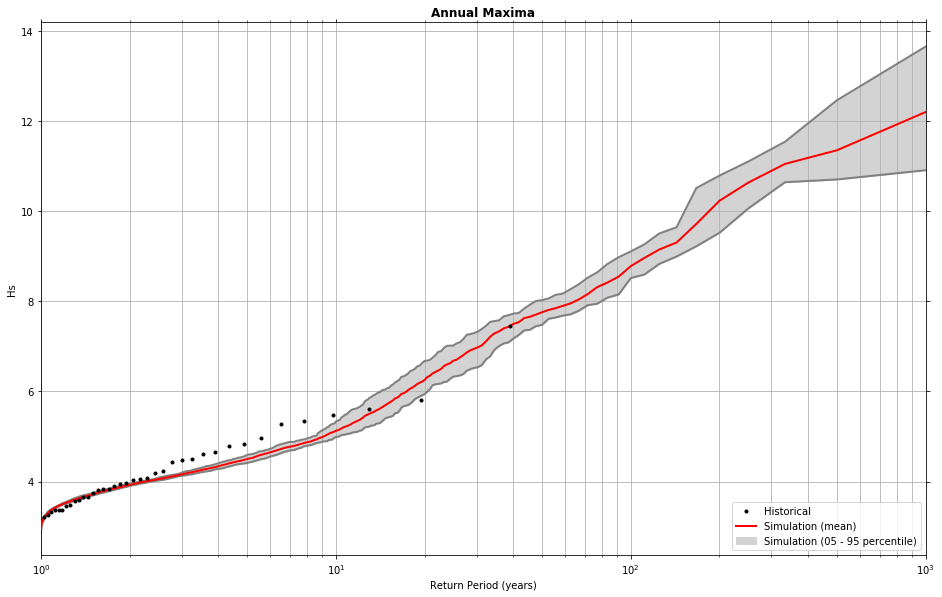

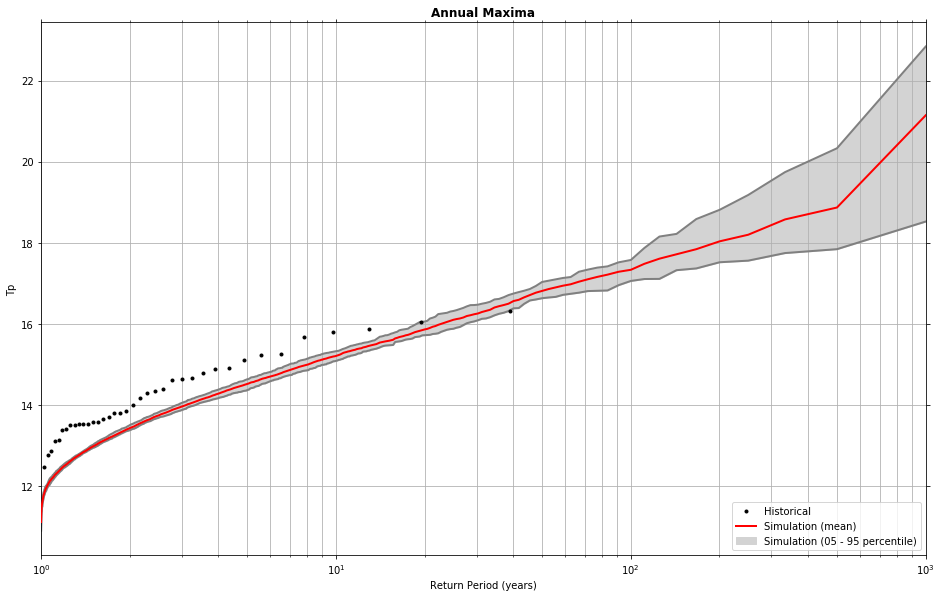

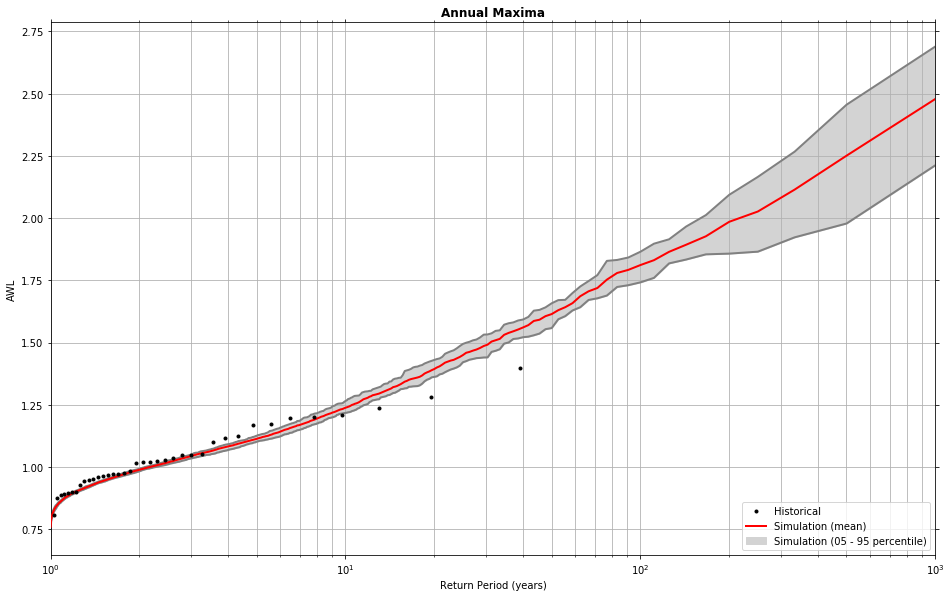

In [5]:
# compare historical and simulations annual maxima (for storms)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_a], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    

In [6]:
# Annual Maxima Location (for one DWTs/WAVEs simulation)

# index simulation
n_sim = 0 
WVS_sim_a = l_WVS_sim_a[n_sim]

# aux func to select all dataset variables at max by groups
def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})

# Locate Annual maxima dates
vn = 'AWL'
hist_Max = WVS_hist.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]
sim_Max = WVS_sim_a.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]


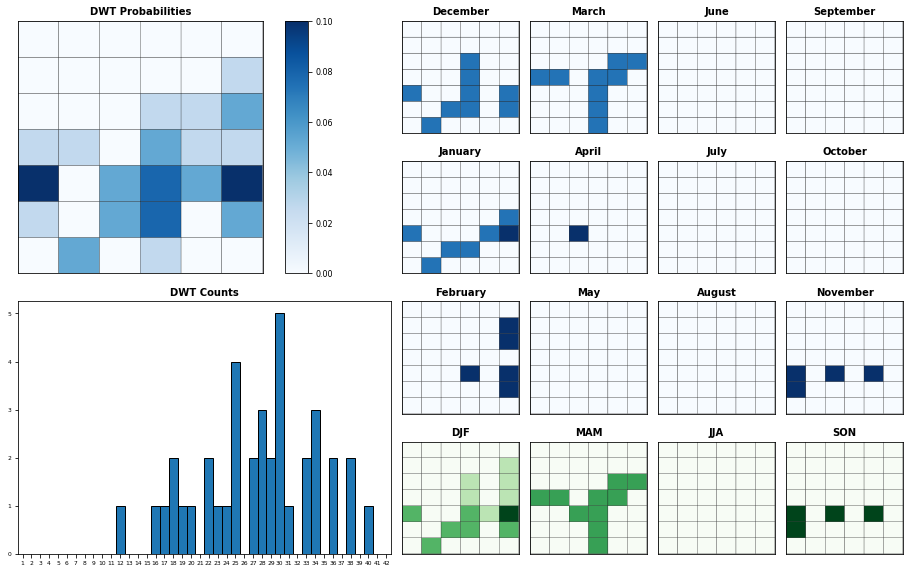

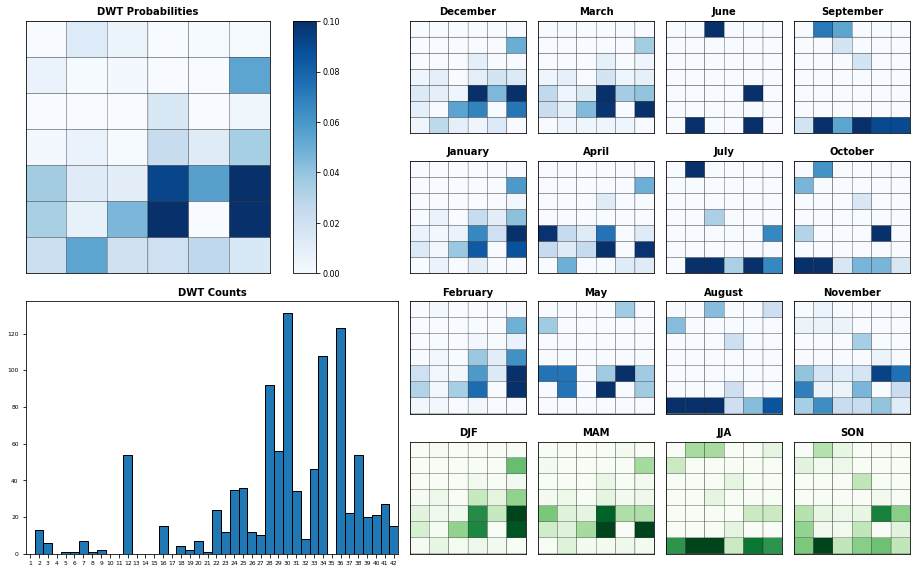

In [7]:
# Annual Maxima DWT probabilities 

n_clusters = 42

# pad DWTs to hourly
DWTs_fit_h = DWTs_fit.resample(time='1h').pad()

# DWTs at AWL annual maxima
hist_DWTs = DWTs_fit_h.sel(time=hist_Max).bmus
sim_DWTs = WVS_sim_a.sel(time=sim_Max).DWT

print(hist_DWTs)

# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs, hist_Max, n_clusters);
Plot_DWTs_Probs(sim_DWTs, sim_Max, n_clusters);


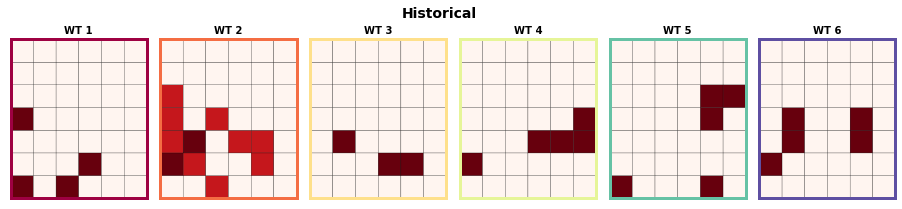

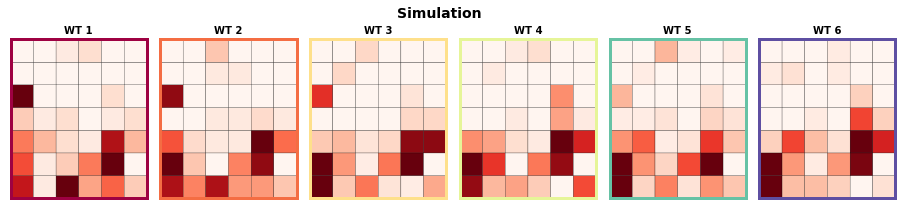

In [8]:
# Annual Maxima AWTs/DWTs Probabilities 

n_clusters_AWT = 6
n_clusters_DWT = 42

# Load historical and simulated AWTs
AWT_hist, _ = db.Load_AWTs_DWTs_Plots_hist()
AWT_sim, _ = db.Load_AWTs_DWTs_Plots_sim(n_sim=n_sim)

# pad AWTs to hourly
AWT_hist_h = AWT_hist.resample(time='1h').pad()

# Select data at annual maxima
hist_AWTs = AWT_hist_h.sel(time=hist_Max).bmus.values[:]
sim_AWTs = AWT_sim.sel(time=sim_Max).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs, hist_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical'
);
Plot_Probs_WT_WT(
    sim_AWTs, sim_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);



## Climate Emulator - Peaks Over Threshold

In [9]:
# --------------------------------------
# Extremes POT

percentile = 99

# Get independent event peaks
hist_POT = POT(WVS_hist, vn, percentile)
sim_POT = POT(WVS_sim_a, vn, percentile)

# TODO
#Plot_PeaksOverThreshold(hist_POT)
#Plot_PeaksOverThreshold(sim_POT)

# TODO
#Plot_ReturnPeriodValidation(hist_POT, sim_POT);

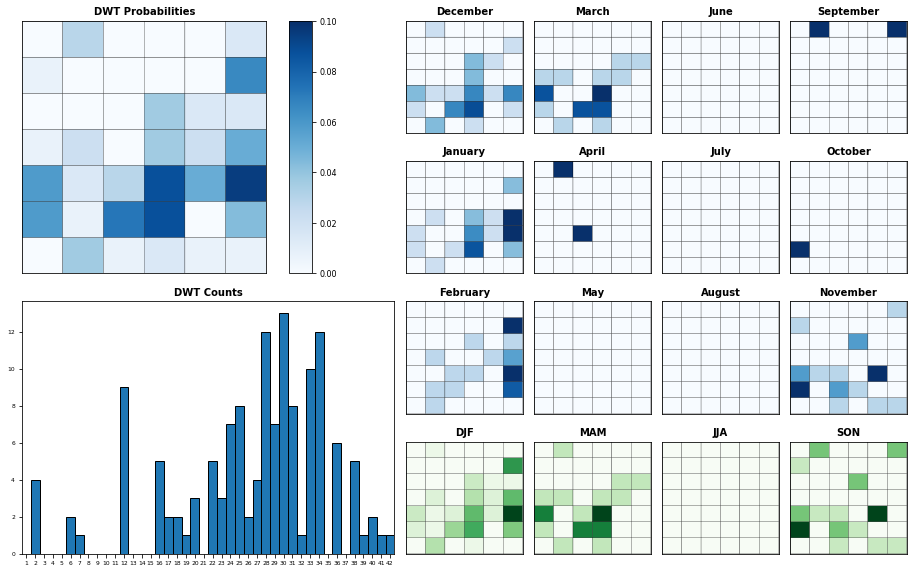

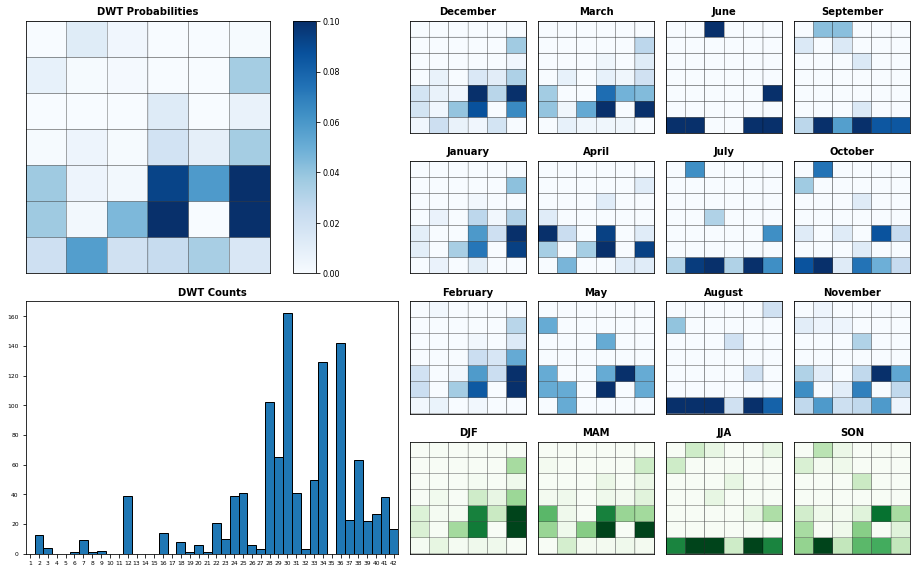

In [10]:
# POT DWT probabilities 

n_clusters = 42

# pad DWTs to hourly
DWTs_fit_h = DWTs_fit.resample(time='1h').pad()

# DWTs at AWL annual maxima
hist_DWTs = DWTs_fit_h.sel(time=hist_POT.time).bmus
sim_DWTs = WVS_sim_a.sel(time=sim_POT.time).DWT


# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs, hist_POT.time.values[:], n_clusters);
Plot_DWTs_Probs(sim_DWTs, sim_POT.time.values[:], n_clusters);


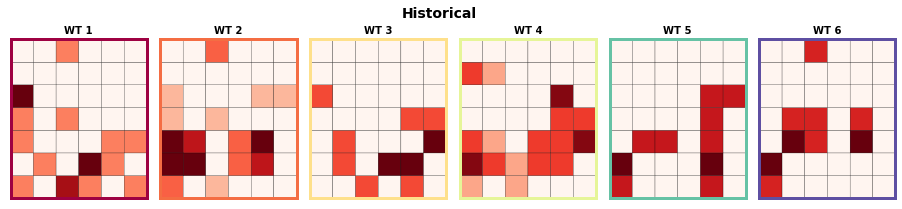

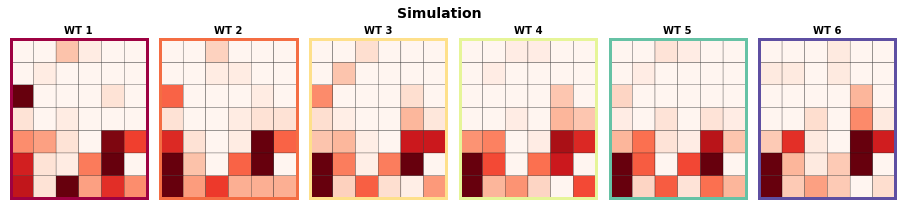

In [11]:
# POT AWTs/DWTs Probabilities 

# pad AWTs to hourly
AWT_hist_h = AWT_hist.resample(time='1h').pad()

# Select data at annual maxima
hist_AWTs = AWT_hist_h.sel(time=hist_POT.time).bmus.values[:]
sim_AWTs = AWT_sim.sel(time=sim_POT.time).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs, hist_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical'
);
Plot_Probs_WT_WT(
    sim_AWTs, sim_DWTs, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);
